# Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib as mpl

# MNIST

In [3]:
# from sklearn.datasets import fetch_openml

# X, y = fetch_openml('mnist_784',
#                     version=1,
#                     as_frame=True,
#                     return_X_y=True,
#                     data_home='data')
# y = y.astype(np.int8)
# X.to_feather('data/mnist_784_X.feather')
# y.to_frame().to_feather('data/mnist_784_y.feather')
X = pd.read_feather('data/mnist_784_X.feather')
y = pd.read_feather('data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000, 1)

In [6]:
28 * 28

784

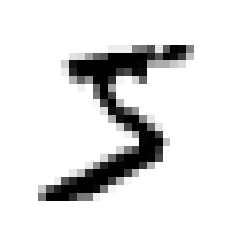

In [9]:
some_digit = X[0]

plt.imshow(some_digit.reshape(28, 28), cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [10]:
y[0]

array([5], dtype=int8)

In [11]:
def plot_digit(data, ax):
    image = data.reshape(28, 28)
    ax.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    ax.axis("off")

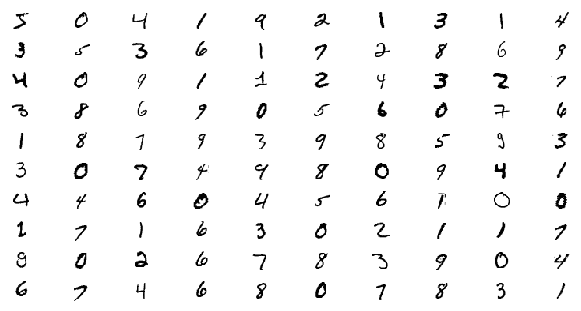

In [13]:
_, axes = plt.subplots(10,
                       10,
                       figsize=(6, 3),
                       dpi=100,
                       constrained_layout=True)

example_images = X[:100]

for ind, ax in enumerate(axes.flatten()):
    img_data = example_images[ind]
    plot_digit(img_data, ax)

plt.show()

In [14]:
y[0]

array([5], dtype=int8)

In [15]:
y = y.astype(np.int32)

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

In [29]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5 = y_train_5.ravel()
y_test_5 = y_test_5.ravel()

In [18]:
from sklearn.linear_model import SGDClassifier

In [28]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [21]:
from sklearn.model_selection import cross_val_score

In [30]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [31]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [32]:
from sklearn.base import BaseEstimator

In [33]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [34]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [38]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

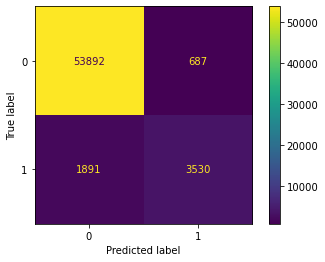

In [39]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [40]:
y_train_perfect_predictions = y_train_5
cm2 = confusion_matrix(y_train_5, y_train_perfect_predictions)
cm2

array([[54579,     0],
       [    0,  5421]])

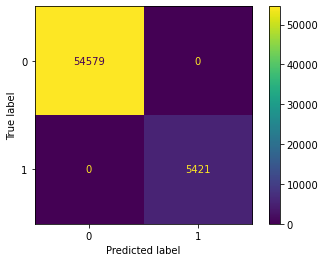

In [41]:
cm_display = ConfusionMatrixDisplay(cm2).plot()

In [42]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [43]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [44]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [46]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [47]:
y_some_digit_pred

array([ True])

In [48]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [51]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [52]:
def plot_precision_recall_vs_threshold(ax, precisions, recalls, thresholds):
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
    ax.legend(loc="center right")
    ax.set(xlabel="Threshold")
    ax.grid(True)

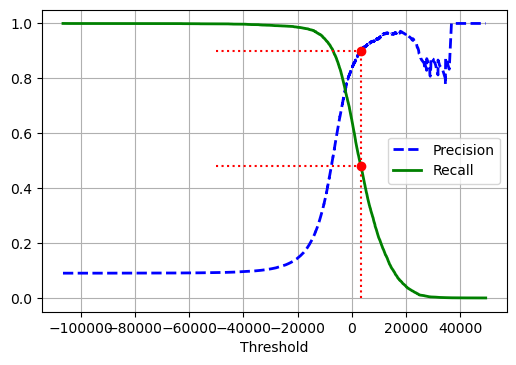

In [53]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_precision_recall_vs_threshold(ax, precisions, recalls, thresholds)

ax.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
ax.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
ax.plot([-50000, threshold_90_precision],
        [recall_90_precision, recall_90_precision], "r:")
ax.plot([threshold_90_precision], [0.9], "ro")
ax.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [54]:
(y_train_pred == (y_scores > 0)).all()

True

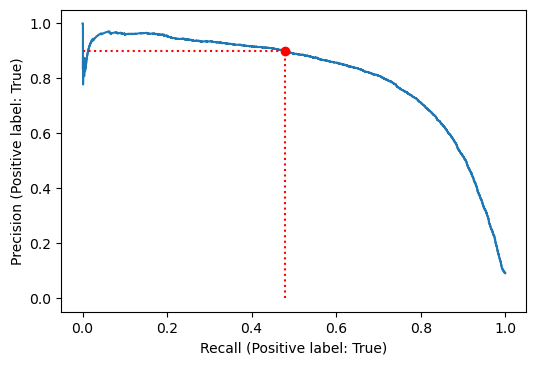

In [55]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

pr_display = PrecisionRecallDisplay(precision=precisions,
                                    recall=recalls,
                                    pos_label=sgd_clf.classes_[1]).plot(ax=ax)

ax.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
ax.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
ax.plot([recall_90_precision], [0.9], "ro")

plt.show()

In [56]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [57]:
threshold_90_precision

3370.0194991439557

In [58]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [59]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [60]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [61]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, roc_auc_score

In [62]:
fpr, tpr, thresholds = roc_curve(y_train_5,
                                 y_scores,
                                 pos_label=sgd_clf.classes_[1])

In [63]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9604938554008616

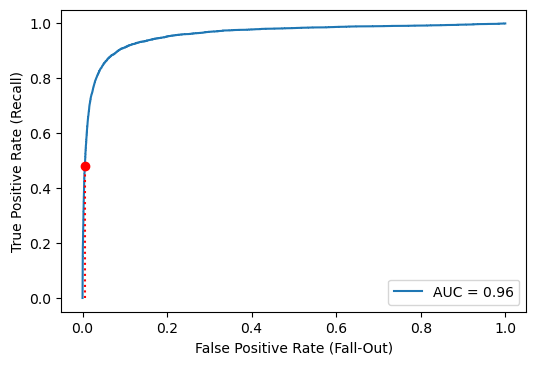

In [64]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
ax.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
ax.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
ax.plot([fpr_90], [recall_90_precision], "ro")
ax.set(xlabel='False Positive Rate (Fall-Out)',
       ylabel='True Positive Rate (Recall)')
plt.show()

In [65]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [68]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

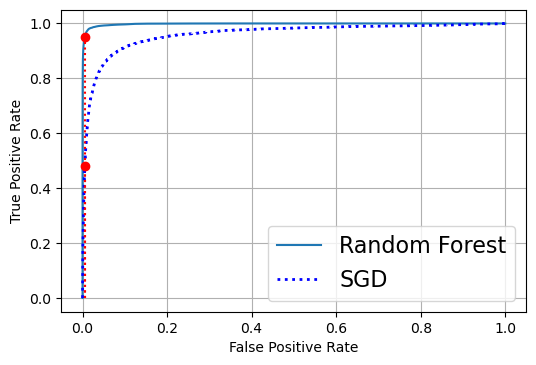

In [69]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

roc_auc = auc(fpr_forest, tpr_forest)
roc_display = RocCurveDisplay(fpr=fpr_forest, tpr=tpr_forest,
                              roc_auc=roc_auc).plot(ax=ax)

roc_display.line_.set_label("Random Forest")
ax.plot(fpr, tpr, "b:", lw=2, label="SGD")
ax.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
ax.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
ax.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
ax.plot([fpr_90], [recall_90_precision], "ro")
ax.plot([fpr_90], [recall_for_forest], "ro")
ax.grid(True)
ax.legend(loc="lower right", fontsize=16)
plt.show()

In [70]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [71]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [72]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass classification

In [73]:
from sklearn.svm import SVC

In [88]:
y_train = y_train.ravel()

In [89]:
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=int32)

In [75]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [76]:
np.argmax(some_digit_scores)

5

In [77]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [78]:
svm_clf.classes_[5]

5

In [79]:
from sklearn.multiclass import OneVsRestClassifier

In [80]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=int32)

In [81]:
len(ovr_clf.estimators_)

10

In [90]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [83]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [84]:
# The following two cells may take close to 30 minutes to run, or more depending on your hardware.
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler

ImportError: cannot import name 'StandardScalerr' from 'sklearn.preprocessing' (/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/preprocessing/__init__.py)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

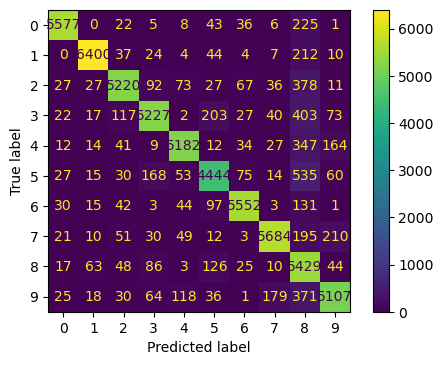

In [ ]:
_, ax = plt.subplots(figsize=(8, 6), dpi=100)

cm_display = ConfusionMatrixDisplay(conf_mx).plot(ax=ax)

In [ ]:
def plot_digit(ax, data):
    image = data.reshape(28, 28)
    ax.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    ax.axis("off")

In [ ]:
from itertools import product

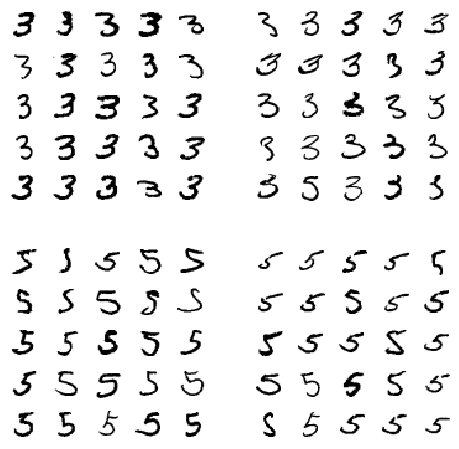

In [ ]:
prod = product([3, 5], repeat=2)
prod2 = product([0, 1], repeat=2)

fig = plt.figure(figsize=(8, 8))
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.2)

for p, (a, b) in zip(prod, prod2):
    inner_grid = outer_grid[a, b].subgridspec(5, 5)
    axes = inner_grid.subplots()

    X_c = X_train[(y_train == p[0]) & (y_train_pred == p[1])][:25]

    for ind, ax in enumerate(axes.flatten()):
        plot_digit(ax, X_c.iloc[ind, :].to_numpy())

plt.show()

# Multilabel classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [ ]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

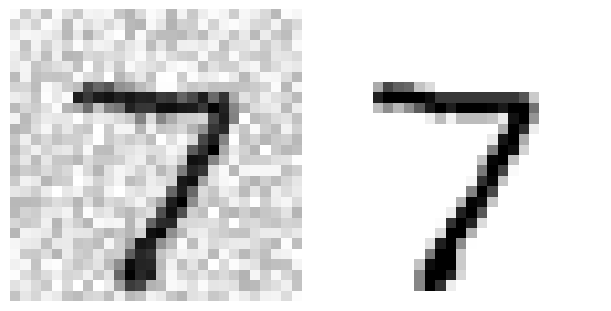

In [ ]:
some_index = 0
_, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100, constrained_layout=True)

plot_digit(axes[0], X_test_mod.to_numpy()[some_index])
plot_digit(axes[1], y_test_mod.to_numpy()[some_index])
plt.show()

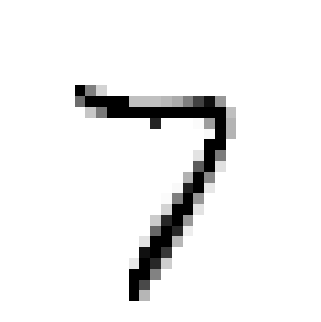

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_digit(ax, clean_digit)

# Random classifier

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf,
                                 X_train,
                                 y_train_5,
                                 cv=3,
                                 method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fpr=[0. 1.], tpr=[0. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Text(0.5, 0, 'False Positive Rate (Fall-Out)'),
 Text(0, 0.5, 'True Positive Rate (Recall)')]

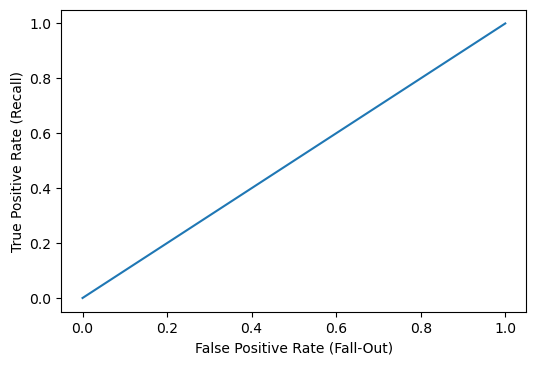

In [ ]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

RocCurveDisplay(fprr, tprr).plot(ax=ax)
ax.set(xlabel='False Positive Rate (Fall-Out)',
       ylabel='True Positive Rate (Recall)')

# KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_knn_pred)

0.9714

In [ ]:
from scipy.ndimage.interpolation import shift

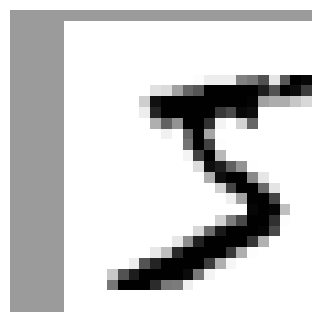

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(ax, shift_digit(some_digit, 5, 1, new=100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit,
                                         axis=1,
                                         arr=X_train,
                                         dx=dx,
                                         dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [ ]:
ambiguous_digit = X_test.iloc[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

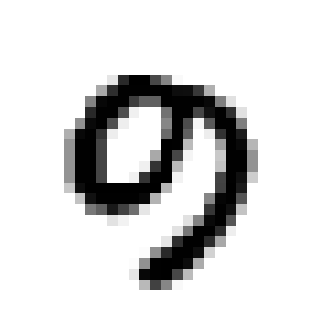

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_digit(ax, ambiguous_digit.to_numpy())

# Data Augmentation

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    shifted_image = shift(image.reshape(28, 28), [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

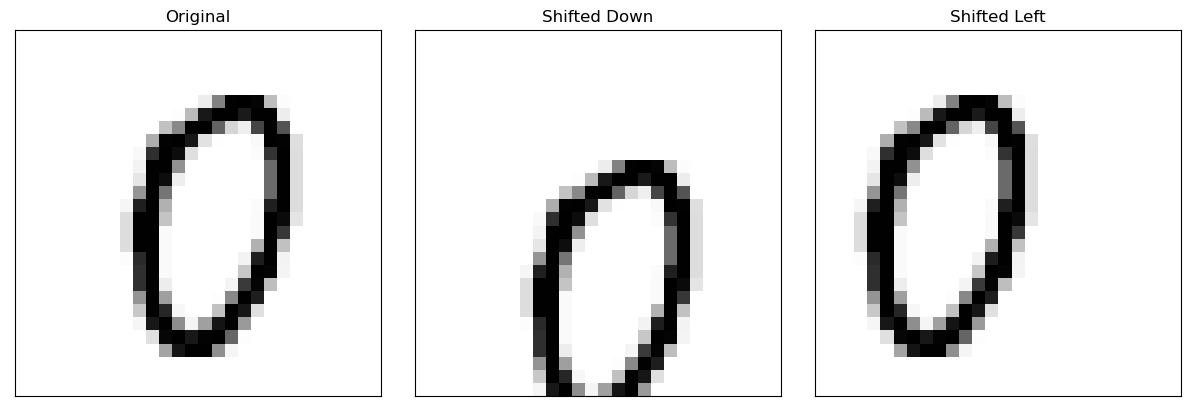

In [ ]:
image = X_train.iloc[1000].to_numpy()
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

titles = ["Original", "Shifted Down", "Shifted Left"]
imgs = [image, shifted_image_down, shifted_image_left]

_, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100, constrained_layout=True)

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img.reshape(28, 28),
              interpolation="nearest",
              cmap="Greys")
    ax.set(xticks=[], yticks=[], title=title)

plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train.to_numpy(), y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented, dtype=object)
y_train_augmented = np.array(y_train_augmented)

/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_42954/3622122226.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_augmented = np.array(X_train_augmented)


In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=5,
                               algorithm='auto',
                               weights='distance')

In [ ]:
# knn_clf.fit(X_train_augmented, y_train_augmented)

**Warning**: the following cell may take close to an hour to run, depending on your hardware.

In [ ]:
# y_pred = knn_clf.predict(X_test)
# accuracy_score(y_test, y_pred)

By simply augmenting the data, we got a 0.5% accuracy boost. :)

# Tackle the Titanic dataset

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

In [ ]:
train_data = pd.read_csv("data/titanic_train.csv")
test_data = pd.read_csv("data/titanic_test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [ ]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [ ]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines. We will reuse the `DataframeSelector` we built in the previous chapter to select specific attributes from the `DataFrame`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Let's build the pipeline for the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [ ]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the regular `SimpleImputer` does not work on those):

In [ ]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series(
            [X[c].value_counts().index[0] for c in X], index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

Now we can build the pipeline for the categorical attributes:

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines:

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [ ]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

Great, our model is trained, let's use it to make predictions on the test set:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a `RandomForestClassifier`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 × IQR$ is a flier, and so is any score greater than $Q3 + 1.5 × IQR$.

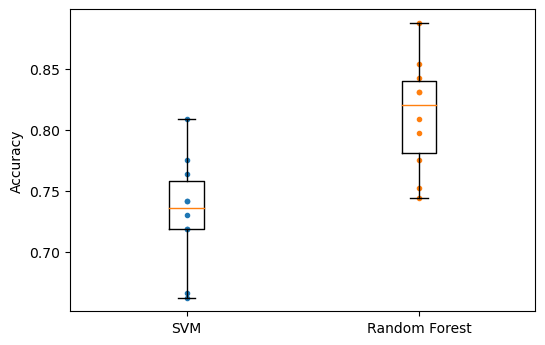

In [ ]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot([1] * 10, svm_scores, ".")
ax.plot([2] * 10, forest_scores, ".")
ax.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
ax.set(ylabel="Accuracy")
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
